# 🦒 Running Deep Learning Models with BioEngine ⚙️☁️

Welcome to this tutorial! We'll guide you through running image analysis models from [BioImage.IO](https://bioimage.io) using the BioEngine server.

We'll show you how to:
1. Load an image,
2. Reshape it according to each model's specifications (called `RDF` – a metadata format describing the models hosted on [BioImage.IO](https://bioimage.io)),
3. Send the image (as a numpy array) to the BioEngine server to run the models. 🚀

All models showcased are available in the [BioImage.IO Model Zoo](https://bioimage.io/#). You can also adapt this tutorial for other models in the zoo! 🧑‍🔬

⚠️ **Note:** The data will be sent to a remote server ([https://hypha.bioimage.io](https://hypha.bioimage.io)) run by the AI4Life team. This service is for evaluation purposes only and may change without notice. If you're looking for an on-prem solution (HPC or Kubernetes), check out the deployment guidelines here: [Deployment Toolkits](https://github.com/bioimage-io/bioengine/tree/main?tab=readme-ov-file#deployment-toolkits).

If you're using your own instance, be sure to update the server URL (`https://hypha.bioimage.io`) and the Triton service ID (`triton-client`) accordingly. 🔧

## Installation and module imports

In [1]:
try:
    # For pyodide in the browser
    import micropip
    await micropip.install(['imjoy-rpc', 'kaibu-utils', 'pyodide-http', 'requests'])
    
    # 2. Patch requests
    import pyodide_http
    pyodide_http.patch_all()  # Patch all libraries
except ImportError:
    # For native python with pip
    import subprocess
    subprocess.call(['pip', 'install', 'imjoy-rpc', 'kaibu-utils'])

import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from imjoy_rpc.hypha import connect_to_server
from kaibu_utils import fetch_image

In [2]:
# Server URL: For this workshop we will use the hypha.bioimage.io server
SERVER_URL = "https://hypha.bioimage.io"

# Running UNet membrane segmentation model via the BioEngine

## Download an example image

example image downloaded:  (512, 512)


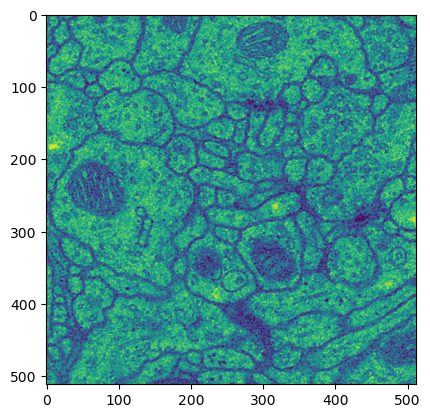

In [3]:
image = await fetch_image('https://zenodo.org/api/records/5906839/files/sample_input_0.tif/content')
image = image.astype('float32')
print("example image downloaded: ", image.shape)
plt.imshow(image)
plt.show()

## Connect to the server

In [4]:
server = await connect_to_server(
        {"server_url": SERVER_URL, "method_timeout": 3000}
    )
triton = await server.get_service("triton-client")

## View the RDF

This helps to verify the expected input format and other model details

In [5]:
import json
ret = await triton.execute(inputs=[{'inputs': None, "model_id": "creative-panda", 'return_rdf':True}],
                           model_name="bioengine-model-runner",
                           serialization="imjoy",
                          )
model_rdf = ret['result']['rdf']
print(json.dumps(model_rdf, indent=4))

{
    "type": "model",
    "weights": {
        "keras_hdf5": {
            "source": "https://zenodo.org/api/records/5906839/files/keras_weights.hdf5/content",
            "tensorflow_version": "1.15",
            "sha256": "cdc0cfcc13d01f75a93b25599167bf7cf1572c0c276ea415dccbbe1d143b1489"
        },
        "tensorflow_saved_model_bundle": {
            "source": "https://zenodo.org/api/records/5906839/files/tf_weights.zip/content",
            "tensorflow_version": "1.15",
            "sha256": "34269e6da7caf38a604bb68f2aaa39662f306064f9a35e7cc81bc42049db87af"
        }
    },
    "cite": [
        {
            "url": "https://doi.org/10.1038/s41592-018-0261-2",
            "text": "Falk et al. Nature Methods 2019"
        },
        {
            "url": "https://doi.org/10.1007/978-3-319-24574-4_28",
            "text": "Ronneberger et al. arXiv in 2015"
        },
        {
            "url": "https://doi.org/10.1101/2020.03.20.000133",
            "text": "Lucas von Chamier et a

## Make sure the input image shape is valid

In [6]:
input_image_shape = tuple(model_rdf["inputs"][0]["shape"][1:])
print("Input image shape", input_image_shape)
input_image = image[...,None]
assert input_image.shape == input_image_shape, f"Wrong shape ({input_image.shape}), expected: {input_image_shape}"
print("Valid image shape, ready to go!")

Input image shape (512, 512, 1)
Valid image shape, ready to go!


## Make prediction with the BioEngine

In [7]:
ret = await triton.execute(inputs=[{"inputs":[[input_image]], "model_id": "creative-panda"}],
                           model_name="bioengine-model-runner",
                           serialization="imjoy",
                          )
result = ret["result"]
mask = result['outputs'][0]
print('prediction: ', mask.shape)

prediction:  (1, 512, 512, 1)


## Display the segmentation result

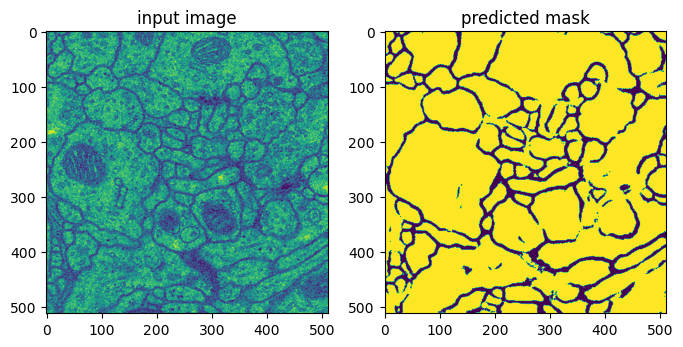

In [8]:
# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(image.astype('uint8'))
ax1.set_title('input image')
ax2.imshow(mask[0])
ax2.set_title('predicted mask')
plt.show()

# Running Stardist nuclei segmentation via the BioEngine

prediction:  (1, 512, 512, 33)
Note: use the stardist library to properly post-process this output! https://github.com/stardist/stardist


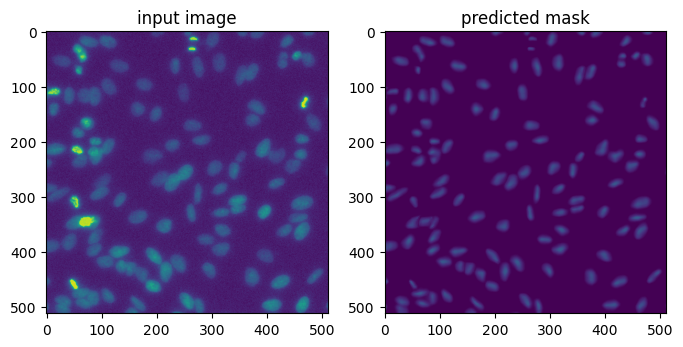

In [9]:
# obtain the model config
image = await fetch_image('https://raw.githubusercontent.com/stardist/stardist/3451a4f9e7b6dcef91b09635cc8fa78939fb0d29/stardist/data/images/img2d.tif', grayscale=True)
image = image.astype('uint16')
param = {'diameter': 30}

# run inference
ret = await triton.execute(inputs=[{
                               "inputs":[[image[...,None]]], 
                               "model_id": "fearless-crab"}], 
                           model_name="bioengine-model-runner",
                           serialization="imjoy",
                          )
result = ret["result"]
mask = result['outputs'][0]
print('prediction: ', mask.shape)
print('Note: use the stardist library to properly post-process this output! https://github.com/stardist/stardist')

# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(image)
ax1.set_title('input image')
ax2.imshow(mask[0, :, :, 0])
ax2.set_title('predicted mask')
plt.show()

** Note: The above model doesn't run the stardist post-processing, so you will get many output channels as output from the U-Net model.

## Trying more models in BioImage.IO

Feel free to find more models at https://bioimage.io, if you want to run a model, please do the following as shown above:
 - Copy the animal nickname id in the model card
 - Print the RDF information so you know what's the expected input shape
 - Load your image, and make sure you reshape or resize it according to the expected input shape using numpy or scikit-image etc.
 - Run the model via `execute`, by passing the model id, image
 - Get the result, extract the image for display according to the output shape according to the RDF.


## Hosting your own BioEngine

While the above demos uses our public free BioEngine server, you can also launch your own bioengine server on a GPU workstation or HPC, and connect to your own BioEngine instance by switching the server URL. If you are interested please following the deployment guidelines here: [Deployment Toolkits](https://github.com/bioimage-io/bioengine/tree/main?tab=readme-ov-file#deployment-toolkits).

If you're using your own instance, be sure to update the server URL (`https://hypha.bioimage.io`) and the Triton service ID (`triton-client`) accordingly.

Please note that the deployment is in early stage, so please if you have any issue or trouble in setting it up, please don't hesitate to reach out via email, forum, web form or github issues: https://github.com/bioimage-io/bioengine/issues

